In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from MHrank import MH_sample 
from eprank import exprop
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
games = data['G'] - 1
num_players = W.shape[0]
num_games = games.shape[0]

# MCMC sampling (this may take a minute)

100%|██████████| 2000/2000 [00:46<00:00, 43.37it/s]


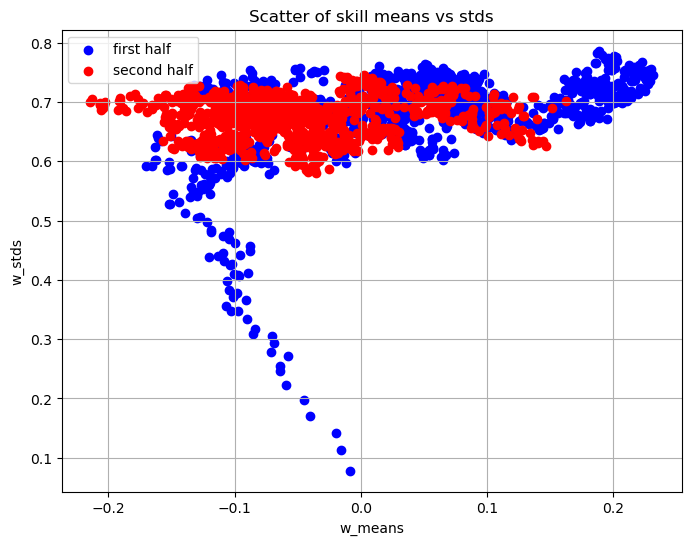

In [3]:
# number of iterations -- the more the better!
num_its = 2000
# perform Metropolis MCMC sampling, skill samples is an num_players x num_samples array
skill_samples, acc, w_means, w_stds = MH_sample(games, num_players, num_its)
wm = np.ravel(w_means)
ws = np.ravel(w_stds)
n = wm.shape[0]
mid = n // 2

plt.figure(figsize=(8,6))
plt.scatter(wm[:mid], ws[:mid], color='blue', label='first half')
plt.scatter(wm[mid:], ws[mid:], color='red', label='second half')
plt.xlabel('w_means')
plt.ylabel('w_stds')
plt.title('Scatter of skill means vs stds')
plt.legend()
plt.grid(True)
plt.show()
# discard the first half of the samples (burn-in period)
skill_samples = skill_samples[:,num_its//2:]

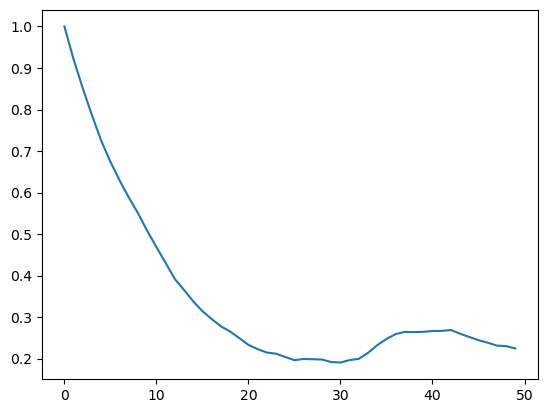

In [4]:
# plotting the autocorrelation function for player i
i = 5
autocor = np.zeros(50)
for t in range(50):
    autocor[t]=pandas.Series.autocorr(pandas.Series(skill_samples[i,:]),lag=t)
plt.plot(autocor)

# Expectation propagation ranking

In [4]:
# run message passing algorithm, returns mean and variance for each player
ep_mean, ep_var = exprop(games, num_players, num_its = 3).T

In [5]:
# Section C
import numpy as np
from scipy.stats import norm
import pandas as pd  # For printing the tables nicely

# --- Code for EP Tables ---
# ASSUMPTION: This code must be run *after* the cell in your notebook
# where you define 'ep_mean' and 'ep_var' by running exprop.
#
# ep_mean, ep_var = exprop(games, num_players, num_its = 3).T

# 1. Define the top 4 players by their names and indices
# (Indices 0-3 correspond to the ATP ranking in the PDF)
player_names = ["Djokovic", "Nadal", "Federer", "Murray"]
player_indices = [0, 1, 2, 3]

# 2. Initialize the 4x4 tables
skill_prob_table = np.zeros((4, 4))
win_prob_table = np.zeros((4, 4))

# 3. Loop through all pairs (i, j) of the top 4
for i in range(4):
    for j in range(4):
        if i == j:
            # The diagonal is 0.5 (prob of beating oneself)
            skill_prob_table[i, j] = 0.5 
            win_prob_table[i, j] = 0.5
            continue
            
        # Get the global index for the players
        idx_i = player_indices[i]
        idx_j = player_indices[j]
        
        # Get the mean and variance for player i and j from EP
        mu_i, var_i = ep_mean[idx_i], ep_var[idx_i]
        mu_j, var_j = ep_mean[idx_j], ep_var[idx_j]
        
        # --- Table 1: Probability of Higher Skill, P(w_i > w_j) ---
        # This is P(w_i - w_j > 0)
        # The difference w_i - w_j is a Gaussian with:
        # mean = mu_i - mu_j
        # variance = var_i + var_j
        mu_diff = mu_i - mu_j
        var_diff_skill = var_i + var_j
        
        # We need P(Z > 0) which is norm.cdf(mean / std_dev)
        prob_skill = norm.cdf(mu_diff / np.sqrt(var_diff_skill))
        skill_prob_table[i, j] = prob_skill
        
        # --- Table 2: Probability of Winning a Match, P(i wins_match j) ---
        # This is P(w_i - w_j + n > 0), where n ~ N(0, 1)
        # The difference is a Gaussian with:
        # mean = mu_i - mu_j
        # variance = var_i + var_j + 1  (<- the only difference!)
        var_diff_win = var_i + var_j + 1
        
        prob_win = norm.cdf(mu_diff / np.sqrt(var_diff_win))
        win_prob_table[i, j] = prob_win

# 4. Format and Print the Tables
df_skill = pd.DataFrame(skill_prob_table, 
                          index=player_names, 
                          columns=player_names)

df_win = pd.DataFrame(win_prob_table, 
                        index=player_names, 
                        columns=player_names)

print("--- Table 1: Probability of Higher Skill, P(w_i > w_j) ---")
print(df_skill.to_string(float_format="%.4f"))
print("\n")
print("--- Table 2: Probability of Winning a Match, P(i wins_match j) ---")
print(df_win.to_string(float_format="%.4f"))

--- Table 1: Probability of Higher Skill, P(w_i > w_j) ---
          Djokovic  Nadal  Federer  Murray
Djokovic    0.5000 1.0000   0.9951  0.9999
Nadal       0.0000 0.5000   0.0239  0.0895
Federer     0.0049 0.9761   0.5000  0.8097
Murray      0.0001 0.9105   0.1903  0.5000


--- Table 2: Probability of Winning a Match, P(i wins_match j) ---
          Djokovic  Nadal  Federer  Murray
Djokovic    0.5000 0.8946   0.7632  0.8262
Nadal       0.1054 0.5000   0.2969  0.3742
Federer     0.2368 0.7031   0.5000  0.5858
Murray      0.1738 0.6258   0.4142  0.5000


In [6]:
# Section D
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# --- Code for Section (d) ---

# 1. Define players and burn-in period
nadal_idx = 1
federer_idx = 2
top_4_indices = [0, 1, 2, 3] # Djokovic, Nadal, Federer, Murray
player_names = ["Djokovic", "Nadal", "Federer", "Murray"]

# num_its should be defined from your MCMC cell (e.g., 2000)
burn_in = num_its // 2
# NOTE: earlier in the notebook `skill_samples` may already have had burn-in removed
# (e.g. `skill_samples = skill_samples[:, num_its//2:]`). If we slice again here
# with the same burn_in value we can end up with zero columns and NaNs.
# To be robust, only slice if the current `skill_samples` has more columns than burn_in.
if skill_samples.shape[1] > burn_in:
    mcmc_samples_burnt = skill_samples[:, burn_in:]
else:
    # skill_samples already represents post-burnin samples (or there are fewer samples than burn_in)
    mcmc_samples_burnt = skill_samples.copy()

print(f"Using {mcmc_samples_burnt.shape[1]} MCMC samples (after {burn_in} burn-in).\n")

# --- 2. Compare Nadal vs. Federer with 3 methods ---

# Method 1: Approximating marginals as independent Gaussians (FLAWED)
mu_nadal_m1 = np.mean(mcmc_samples_burnt[nadal_idx, :])
var_nadal_m1 = np.var(mcmc_samples_burnt[nadal_idx, :])
mu_fed_m1 = np.mean(mcmc_samples_burnt[federer_idx, :])
var_fed_m1 = np.var(mcmc_samples_burnt[federer_idx, :])
prob_m1 = norm.cdf((mu_nadal_m1 - mu_fed_m1) / np.sqrt(var_nadal_m1 + var_fed_m1))
print(f"Method 1 (Marginal Gaussian): P(Nadal > Federer) = {prob_m1:.4f}")

# Method 2: Approximating joint skills as a Gaussian (BETTER, but still FLAWED)
# We need the covariance between Nadal and Federer's samples
cov_matrix_m2 = np.cov(mcmc_samples_burnt[nadal_idx, :], 
                         mcmc_samples_burnt[federer_idx, :])
var_nadal_m2 = cov_matrix_m2[0, 0]
var_fed_m2 = cov_matrix_m2[1, 1]
cov_nadal_fed_m2 = cov_matrix_m2[0, 1]

mu_diff_m2 = mu_nadal_m1 - mu_fed_m1 # Mean is the same
var_diff_m2 = var_nadal_m2 + var_fed_m2 - (2 * cov_nadal_fed_m2)
prob_m2 = norm.cdf(mu_diff_m2 / np.sqrt(var_diff_m2))
print(f"Method 2 (Joint Gaussian):   P(Nadal > Federer) = {prob_m2:.4f}")

# Method 3: Directly from the samples (BEST METHOD)
diff_samples_m3 = mcmc_samples_burnt[nadal_idx, :] - mcmc_samples_burnt[federer_idx, :]
prob_m3 = np.mean(diff_samples_m3 > 0)
print(f"Method 3 (Direct Samples):   P(Nadal > Federer) = {prob_m3:.4f}\n")


# --- 3. Derive 4x4 table using the best method (Method 3) ---

mcmc_skill_table = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        if i == j:
            mcmc_skill_table[i, j] = 0.5
            continue
            
        # Get the global index for the players
        idx_i = top_4_indices[i]
        idx_j = top_4_indices[j]
        
        # Use Method 3: direct comparison of sample chains
        diff_samples = mcmc_samples_burnt[idx_i, :] - mcmc_samples_burnt[idx_j, :]
        mcmc_skill_table[i, j] = np.mean(diff_samples > 0)

# 4. Format and Print the Table for comparison with section (c)
df_mcmc_skill = pd.DataFrame(mcmc_skill_table, 
                             index=player_names, 
                             columns=player_names)

print("--- MCMC 4x4 Skill Table (Method 3) ---")
print(df_mcmc_skill.to_string(float_format="%.4f"))
print("\nCompare this table to the EP Skill Table from section (c).")

Using 1000 MCMC samples (after 1000 burn-in).

Method 1 (Marginal Gaussian): P(Nadal > Federer) = 0.0315
Method 2 (Joint Gaussian):   P(Nadal > Federer) = 0.0352
Method 3 (Direct Samples):   P(Nadal > Federer) = 0.0280

--- MCMC 4x4 Skill Table (Method 3) ---
          Djokovic  Nadal  Federer  Murray
Djokovic    0.5000 1.0000   1.0000  1.0000
Nadal       0.0000 0.5000   0.0280  0.1020
Federer     0.0000 0.9720   0.5000  0.7360
Murray      0.0000 0.8980   0.2640  0.5000

Compare this table to the EP Skill Table from section (c).


Plotting Empirical Ranking (Win / Loss %)...


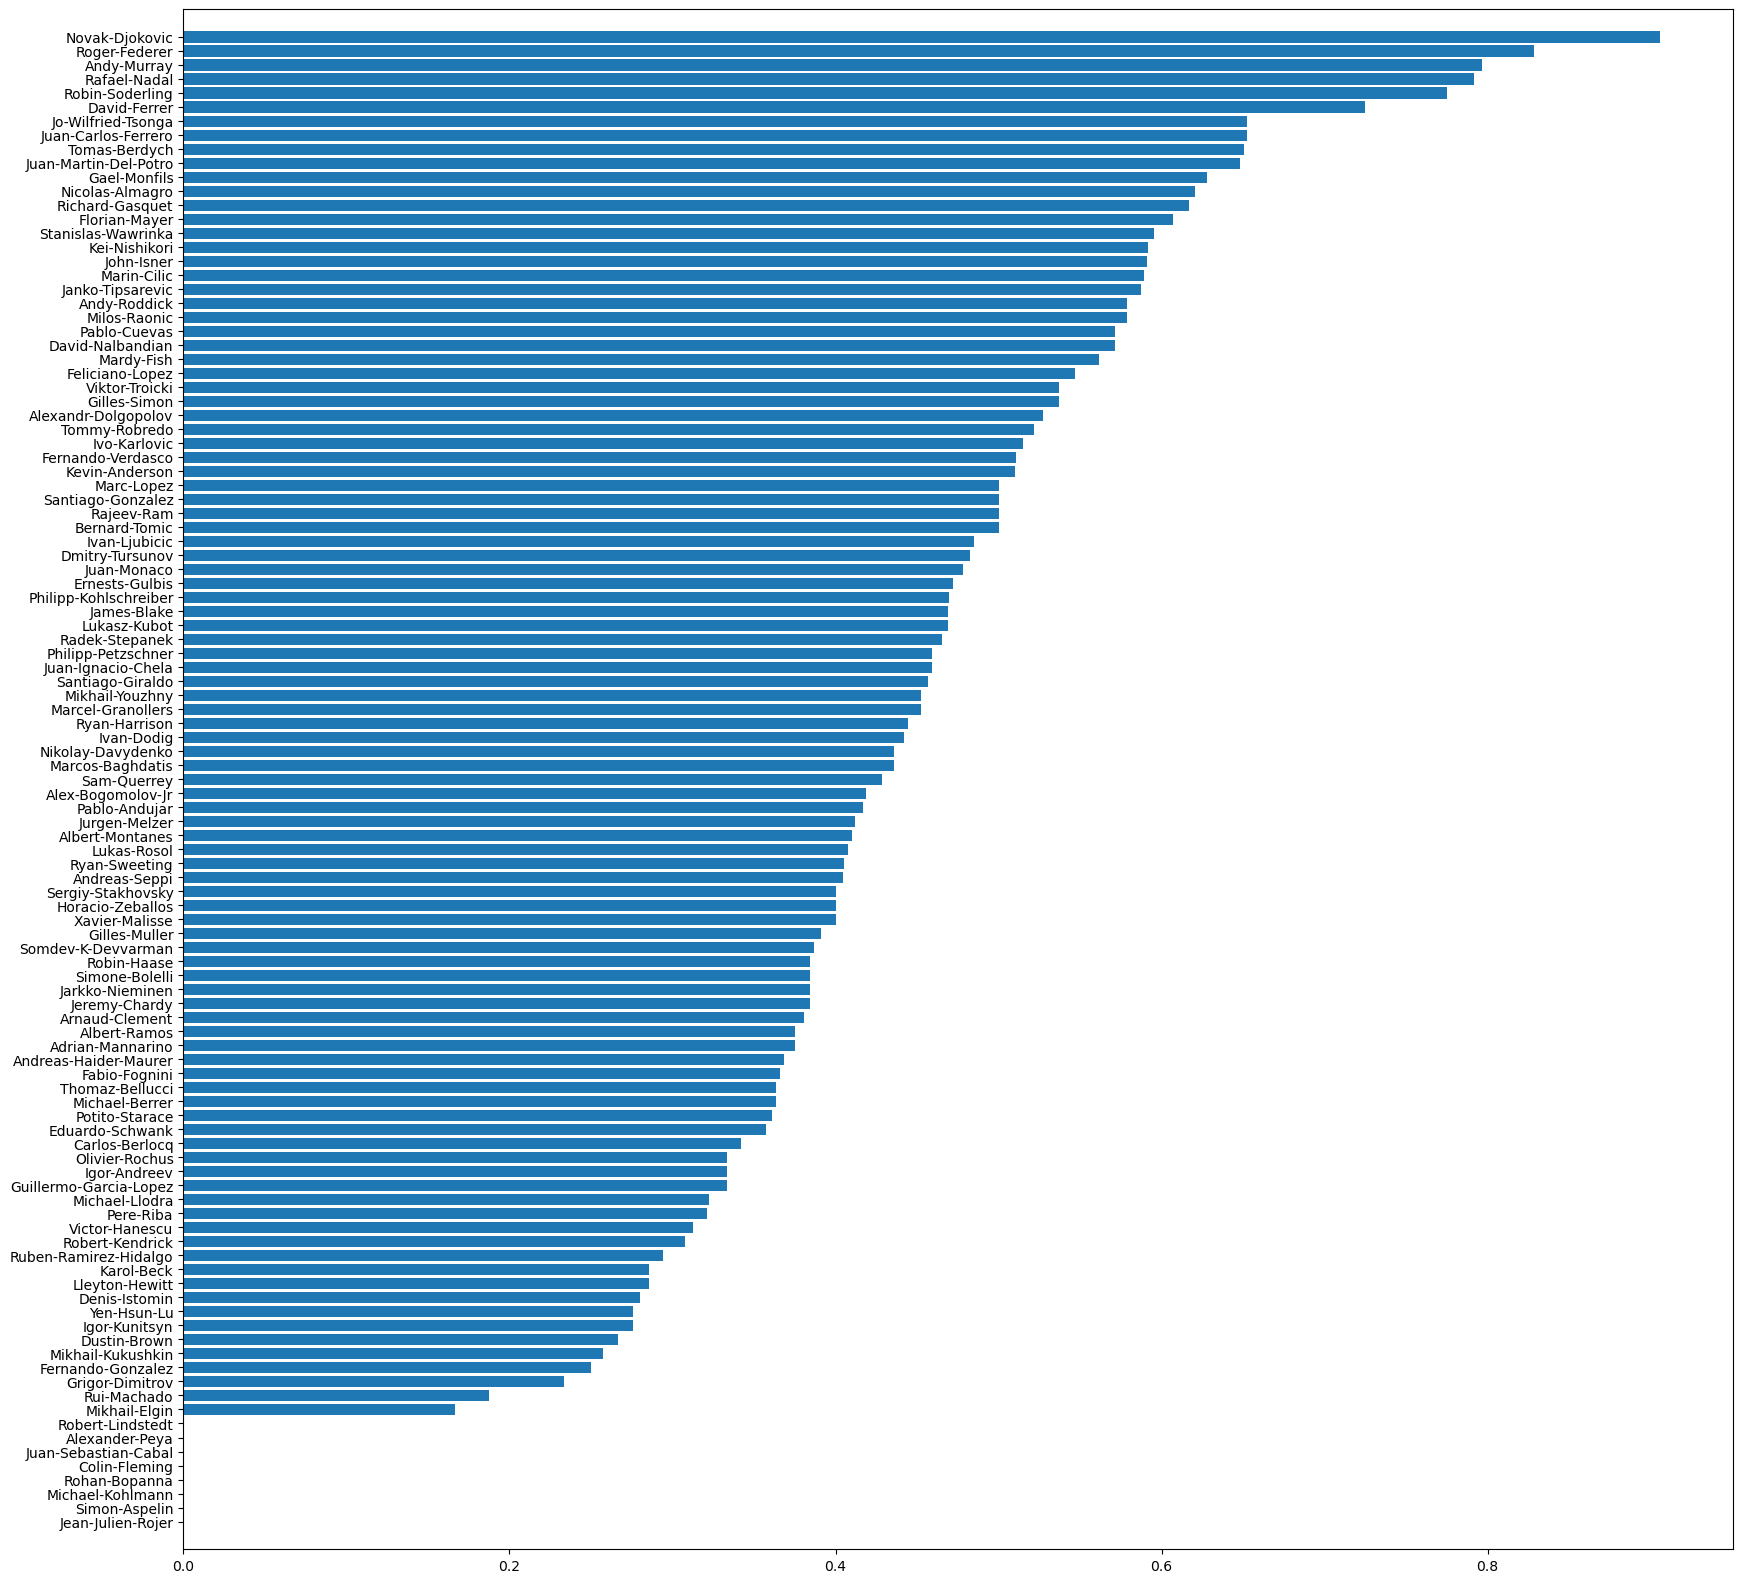

Plotting MCMC-based Ranking (Posterior Mean Skill)...


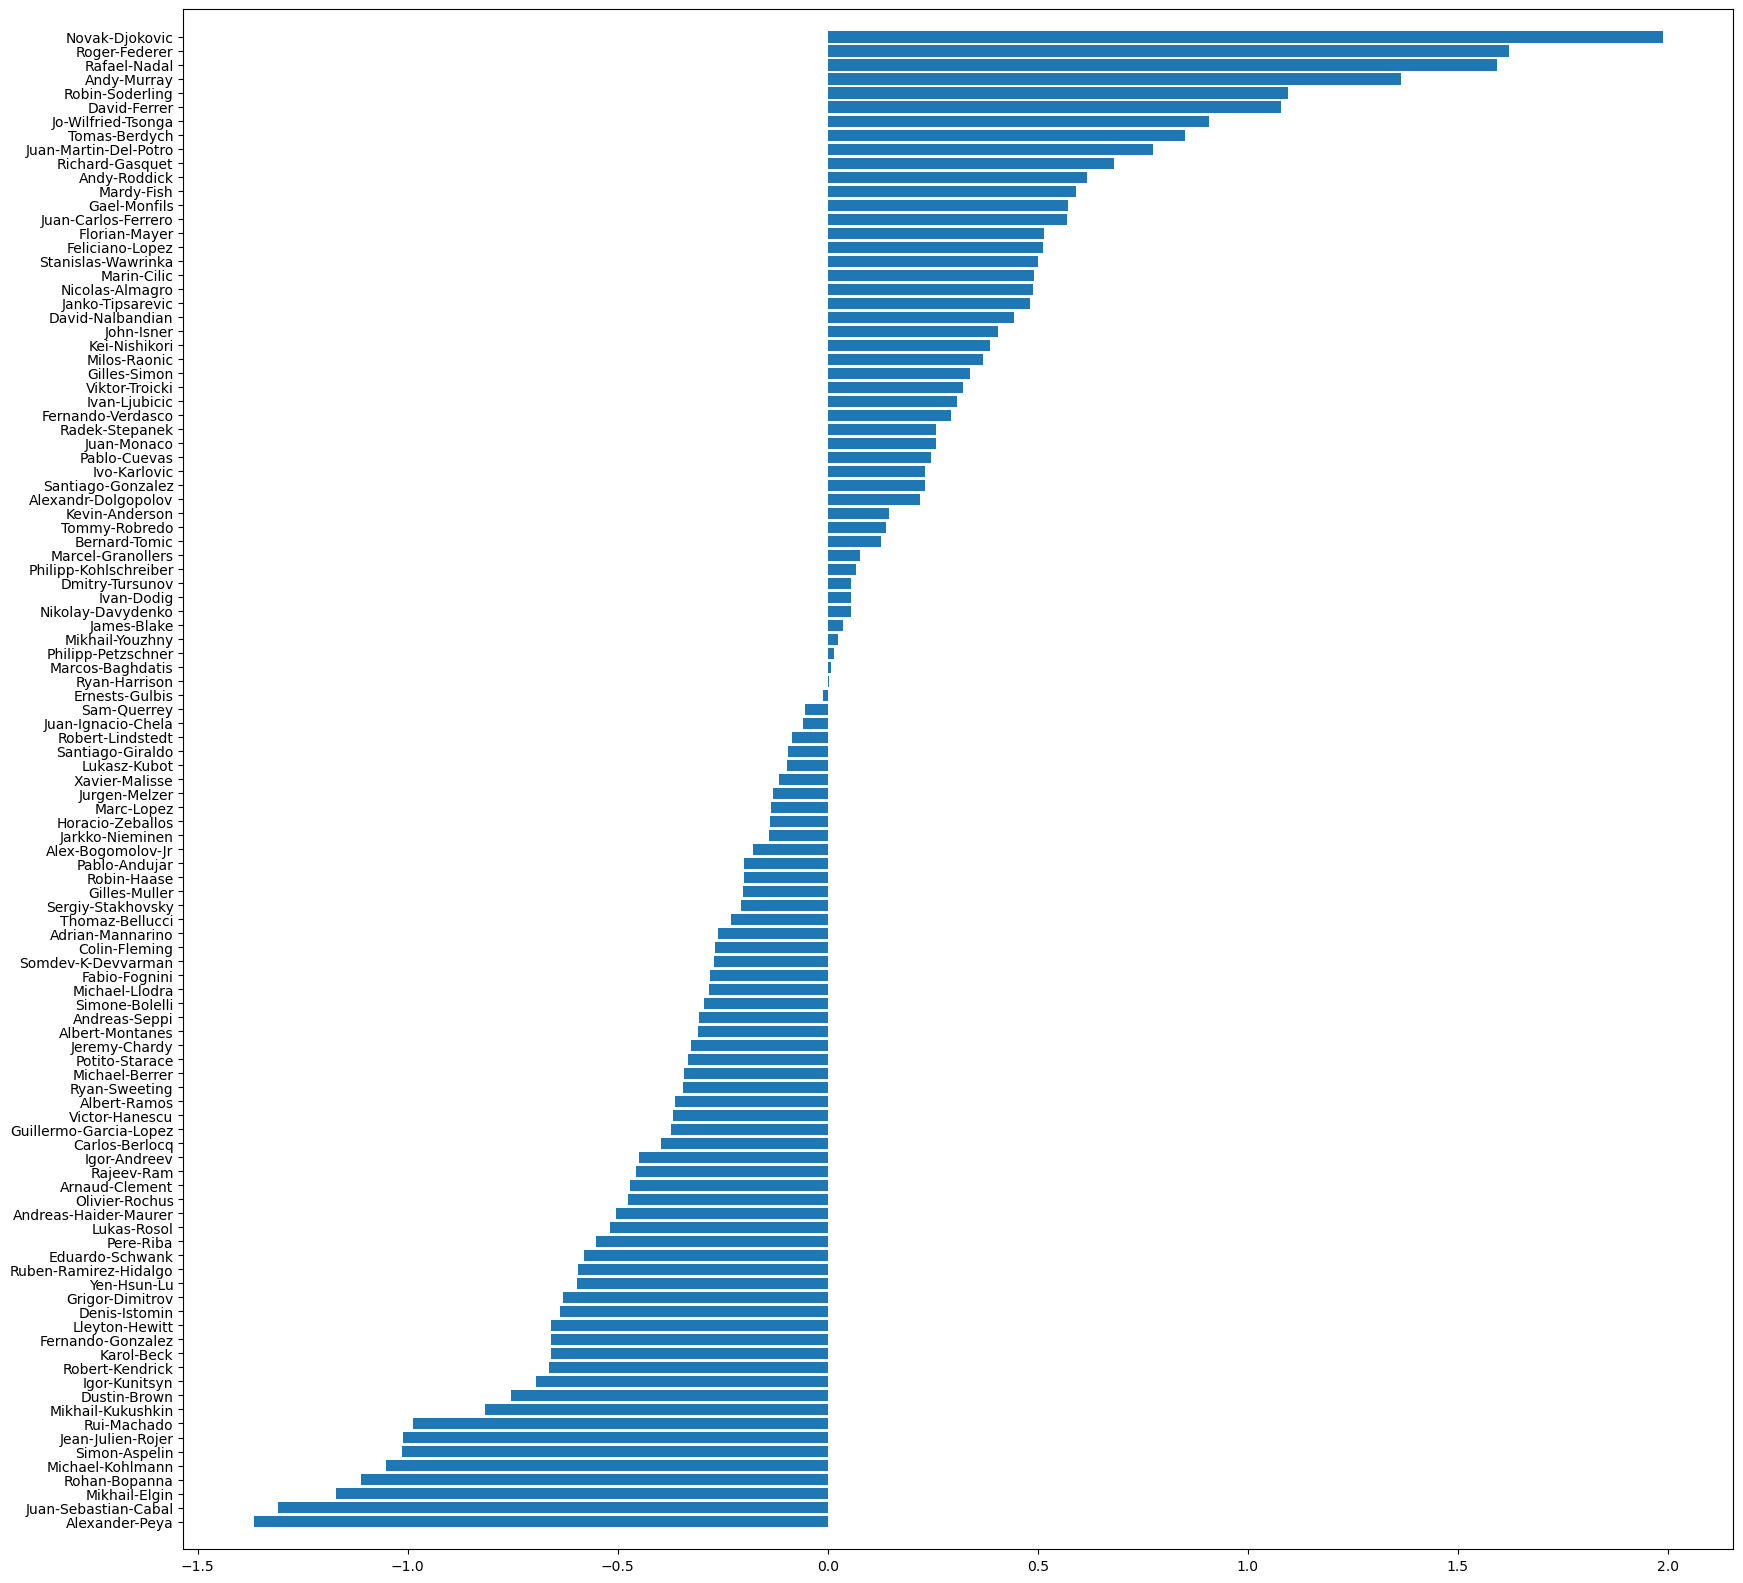

Plotting EP-based Ranking (Posterior Mean Skill)...


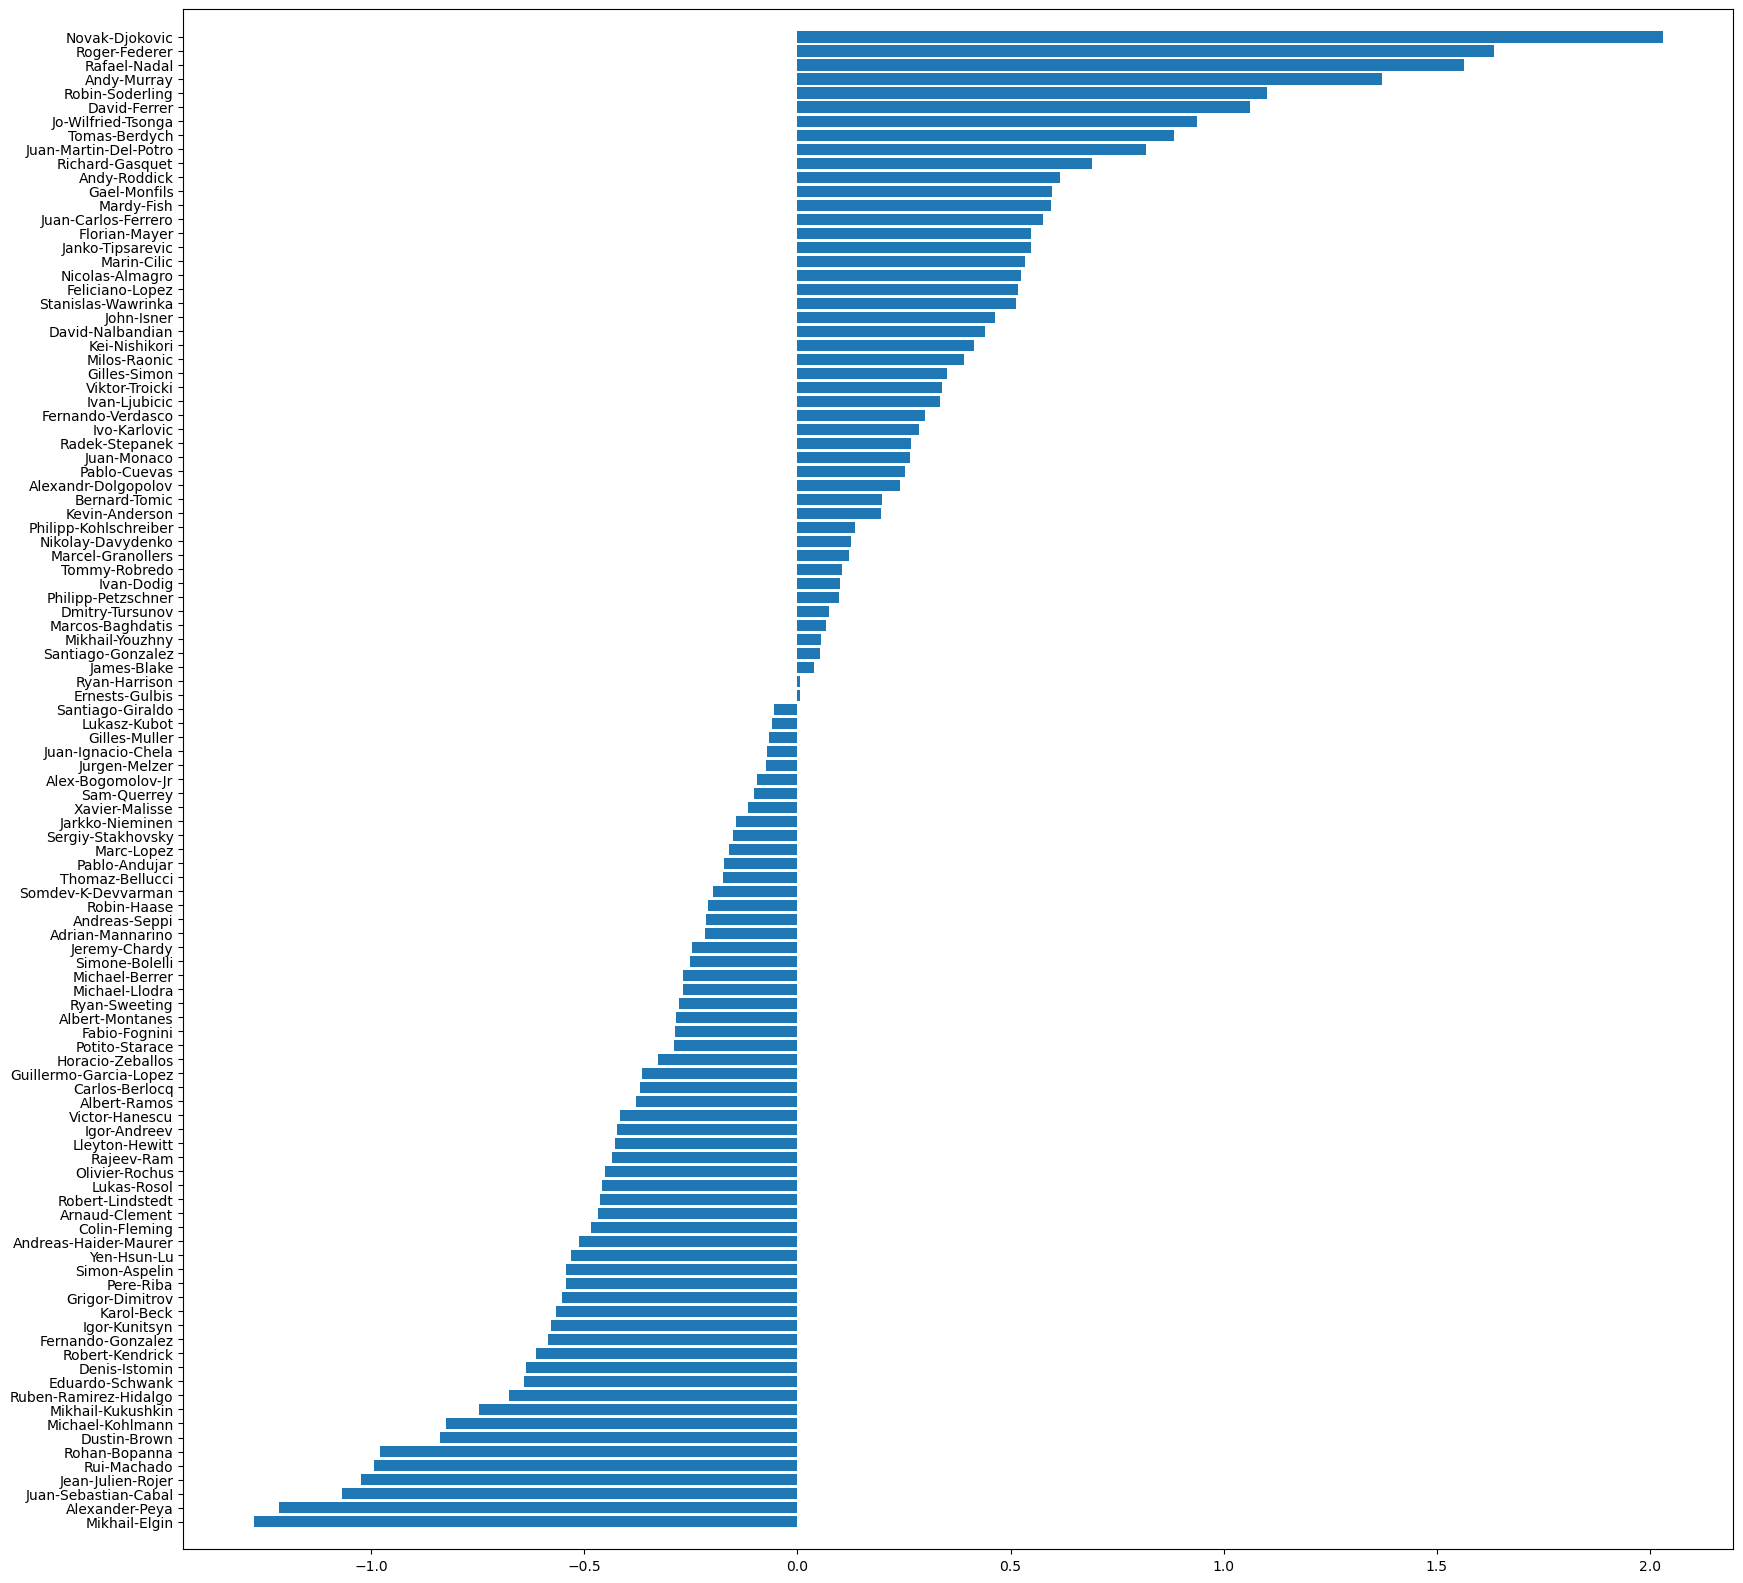

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Code for Section (e) ---
# We need the `sorted_barplot` function.
# Make sure you have imported it from cw2.py
# from cw2 import sorted_barplot 

# --- Method 1: Empirical game outcome averages ---
# (Simple win percentage, ignores opponent strength)

wins = np.zeros(num_players)
losses = np.zeros(num_players)

# Loop over all games to count wins and losses
for g in range(games.shape[0]):
    winner_idx = games[g, 0]
    loser_idx = games[g, 1]
    
    wins[winner_idx] += 1
    losses[loser_idx] += 1

total_games = wins + losses

# Calculate win percentage, handling division by zero for players with 0 games
rank_empirical = np.divide(wins, total_games, 
                           out=np.zeros_like(wins, dtype=float), 
                           where=total_games != 0)


# --- Method 2: Predictions based on Monte Carlo sampling ---
# (Posterior mean skill from MCMC)

# We re-use mcmc_samples_burnt from section (d)
rank_mcmc = np.mean(mcmc_samples_burnt, axis=1) # axis=1 averages over iterations


# --- Method 3: Predictions based on the message passing algorithm ---
# (Posterior mean skill from EP)

rank_ep = ep_mean # This is already the mean skill vector


# --- Plot the rankings ---
# Note: The `sorted_barplot` function (from cw2.py) creates its own figure.
# Call them one by one to see the plots.

print("Plotting Empirical Ranking (Win / Loss %)...")
sorted_barplot(rank_empirical, W)
print("Plotting MCMC-based Ranking (Posterior Mean Skill)...")
sorted_barplot(rank_mcmc, W)

print("Plotting EP-based Ranking (Posterior Mean Skill)...")
sorted_barplot(rank_ep, W)